In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn 
import random
import os

from src.utils.g2d_diff_genodrug_dataset import *
from src.g2dpred_rev import *
from src.scheduler import *


def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


import sys
sys.path.insert(0, './vae_package')


/home/jovyan/hyunho/anaconda3/envs/g2d_diff/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

!nvidia-smi

Mon Mar 24 00:35:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:10:00.0 Off |                    0 |
| N/A   29C    P0              63W / 400W |   1792MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

## G2D-Pred Training Wrapper

In [6]:
import logging
import datetime
from torch import autograd
from torch.autograd import Variable
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr


import numpy
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.utils import shuffle
import copy
class G2D_Pred_Trainer(nn.Module):
    def __init__(self, num_of_genotypes = 1, num_of_dcls = 5, cond_dim = 128,  drug_dim = 128, device = 'cuda'):
        super(G2D_Pred_Trainer, self).__init__()
        


        self.auc_predictor = NCIPREDICTOR(num_of_genotypes = num_of_genotypes, num_of_dcls = num_of_dcls, 
                                          cond_dim = cond_dim, drug_dim = drug_dim, device = device) 

   
            
        
        self.num_of_genotypes = num_of_genotypes
        self.num_of_dcls = num_of_dcls
        self.condim = cond_dim
        self.input_dim = drug_dim
        self.device_name = device
       
        
    def validation(self, dataset_obj, collate_fn):     
        val_loader = DataLoader(dataset_obj, batch_size=128, shuffle=False, drop_last=False, collate_fn=collate_fn)
        pred_list = []
        targ_list = []

        self.auc_predictor.eval()
        for i, batch in tqdm(enumerate(val_loader), total = len(val_loader)):


            ## Batch data load to device
            for key in batch.keys():
                if 'genotype' in key:
                    for mut in batch[key].keys():
                        batch[key][mut] = batch[key][mut].to(device)
                elif key == 'cell_name':
                    None
                elif key == 'drug_name':
                    None
                else:
                    batch[key] = batch[key].to(device)




            pred_auc = self.auc_predictor(batch)
            pred_list.append(pred_auc.squeeze().detach().cpu().numpy())
            targ_list.append(batch['auc'].detach().cpu().numpy())
        pred_list = np.hstack(pred_list)
        targ_list = np.hstack(targ_list)
        
        return np.sqrt(mean_squared_error(targ_list , pred_list)), r2_score(targ_list , pred_list), pearsonr(targ_list, pred_list)[0]
    
        
    def train(self, dataset_obj, collate_fn, train_config: Dict, count, val_dataset_obj, load_model = False, load_path = None, sampler = None):
        
        
        
        lr = train_config['lr']
        batch_size = train_config['batch_size']
        epochs = train_config['epoch']
        train_config['current_epoch'] = 0
        

            
        tr_loader = DataLoader(dataset_obj, batch_size=batch_size, drop_last=True, collate_fn=collate_fn, sampler = sampler)

        
        solver = optim.Adam(self.auc_predictor.parameters(), lr=lr)

        lr_scheduler = NoamLR(optimizer = solver, 
                                 warmup_epochs = [1],
                                 total_epochs = [200],
                                 steps_per_epoch = len(tr_loader),
                                 init_lr = [1e-6],
                                 max_lr = [lr],
                                 final_lr = [1e-5])
        
        mse_loss = nn.MSELoss()
        fin_losses = []
        val_results = []

        max_val = 0
        patience = 0

        for epoch in range(train_config['current_epoch'], epochs):
            
            int_losses = []

            print ("Epoch: %d" %epoch)
            self.auc_predictor.train()
            for i, batch in tqdm(enumerate(tr_loader), total = len(tr_loader)):
         

                ## Batch data load to device
                for key in batch.keys():
                    if 'genotype' in key:
                        for mut in batch[key].keys():
                            batch[key][mut] = batch[key][mut].to(self.device_name)
                    elif key == 'cell_name':
                        None
                    elif key == 'drug_name':
                        None
                    else:
                        batch[key] = batch[key].to(self.device_name)
                

                
   
                pred_auc = self.auc_predictor(batch)
                pred_loss = mse_loss(pred_auc.squeeze(), batch['auc'])

      
                int_losses.append(pred_loss.detach().cpu().numpy())

                
                solver.zero_grad()
                pred_loss.backward()
                solver.step()
                lr_scheduler.step()

    
    
            rmse, r2, pcc = self.validation(val_dataset_obj, collate_fn)
            print(rmse, r2, pcc)
            val_results.append((rmse, r2, pcc))

            t= int(len(np.array(int_losses)) / 1)
            x = []
            for i in range(int(len(np.array(int_losses)) / t)):
                x.append(np.mean(np.array(int_losses)[i*t:(i+1)*t]))
            fin_losses += x

            
            train_config['current_epoch'] = epoch
            ckpt_dict = {

            'predictor_state_dict': self.auc_predictor.state_dict(),

                
            'solver_state_dict': solver.state_dict(),
         
            'losses': fin_losses,
           
            'val_results': val_results,
                
            'configs' : train_config
            }
  
            #torch.save(ckpt_dict, "g2d_pred_revised/250324_predictor_%d_%d.pth"%(count, epoch))
        return None
    
    
        

In [7]:
PREDIFINED_GENOTYPES = ['mut', 'cna', 'cnd']



nci_data = pd.read_csv("data/drug_response_data/original_nci_drug_response_revised_1129.csv").dropna()


mean_auc = nci_data['auc'].mean()
std_auc = nci_data['auc'].std()

nci_data['z_score'] = nci_data['auc'].map(lambda x: np.abs((x-mean_auc)/(std_auc + 1e-8)))


cell2mut = pd.read_csv("data/drug_response_data/original_cell2mut.csv", index_col = 0).rename(columns={'index':'ccle_name'})
cell2cna = pd.read_csv("data/drug_response_data/original_cell2cna.csv", index_col = 0).rename(columns={'index':'ccle_name'})
cell2cnd = pd.read_csv("data/drug_response_data/original_cell2cnd.csv", index_col = 0).rename(columns={'index':'ccle_name'})
drug2smi = pd.read_csv("data/drug_response_data/latent_nci_reconstructed_1129.csv").iloc[:, 0:-1]


train_config = {}
train_config['lr'] = 1e-4
train_config['batch_size'] = 128
train_config['epoch'] = 200


    
    

In [8]:
len(nci_data) // 128

6340

In [9]:
!nvidia-smi

Mon Mar 24 00:36:13 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:10:00.0 Off |                    0 |
| N/A   28C    P0              63W / 400W |   1792MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [10]:
nci_data_test = nci_data.sample(frac = 0.01, random_state = 0)
nci_data_train = pd.concat([nci_data, nci_data_test], axis = 0).drop_duplicates(keep=False)

<Axes: >

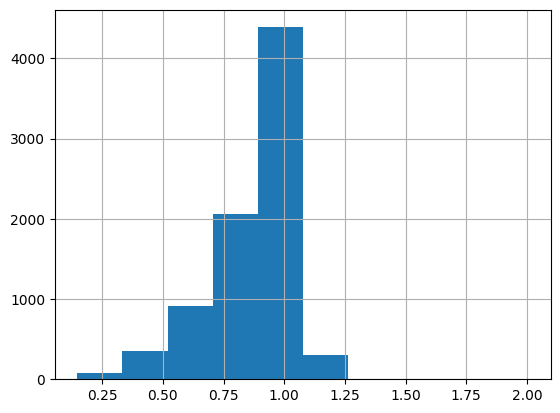

In [11]:
nci_data_test['auc'].hist()

<Axes: >

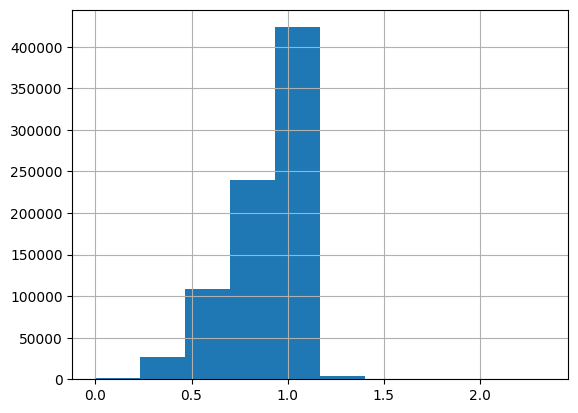

In [12]:
nci_data_train['auc'].hist()

## Cell Result only shows single repeat, repeat = 0

In [13]:
device='cuda:0'
for repeat in range(5):
    set_seed(repeat)
    framework = G2D_Pred_Trainer(num_of_genotypes = 3, num_of_dcls = 5, cond_dim = 128, drug_dim = 128,  device = device)
    framework.to(device).to(torch.float)


    valid = nci_data_train.sample(frac = 0.01, random_state = repeat)
    train = pd.concat([nci_data_train, valid], axis = 0).drop_duplicates(keep=False)


    samples_weight = train['z_score'].values
    samples_weight = torch.from_numpy(samples_weight)
    sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    train = train.iloc[:, 0:4]
    valid = valid.iloc[:, 0:4]


    train_dataset_obj = GenoDrugDataset(train, cell2mut, drug2smi, cna=cell2cna, cnd=cell2cnd)
    val_dataset_obj = GenoDrugDataset(valid, cell2mut, drug2smi, cna=cell2cna, cnd=cell2cnd)
    collate_fn = GenoDrugCollator(genotypes=PREDIFINED_GENOTYPES)

    _ = framework.train(dataset_obj = train_dataset_obj, collate_fn = collate_fn, \
                                         train_config = train_config, val_dataset_obj = val_dataset_obj, count = repeat, sampler = sampler)

Random seed set as 0
NeST neighbor info is used
Epoch: 0


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.17283747 0.09861859497153436 0.46447653375430353
Epoch: 1


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.16876274 0.14061853843155492 0.5001168372925717
Epoch: 2


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]


0.16073602 0.22042250945333952 0.5346854780172482
Epoch: 3


100%|██████████| 63/63 [00:06<00:00,  9.38it/s]


0.15905154 0.23667674688284868 0.5543770887445818
Epoch: 4


100%|██████████| 63/63 [00:06<00:00,  9.35it/s]


0.15345253 0.28947240182984146 0.5785710709632597
Epoch: 5


100%|██████████| 63/63 [00:06<00:00,  9.07it/s]


0.15219021 0.30111415401785235 0.5994916000369819
Epoch: 6


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.1458792 0.3578751767789302 0.6265472860787793
Epoch: 7


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.14453432 0.36966007456992955 0.6433842415118253
Epoch: 8


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.14031965 0.4058859538674592 0.6592520670788072
Epoch: 9


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.13835573 0.42240016407901193 0.6749827619826967
Epoch: 10


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]


0.13396572 0.4584729394133503 0.6913769693387821
Epoch: 11


100%|██████████| 63/63 [00:06<00:00,  9.17it/s]


0.13262013 0.46929676089979955 0.7035174868969656
Epoch: 12


100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


0.12938319 0.4948870300736169 0.718042494035967
Epoch: 13


100%|██████████| 63/63 [00:06<00:00,  9.17it/s]


0.12694134 0.5137730787290695 0.7287019576627887
Epoch: 14


100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


0.124620855 0.5313870495443461 0.7396677875611866
Epoch: 15


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.12267696 0.5458923519956433 0.7488144905729612
Epoch: 16


100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


0.12121934 0.5566194685056469 0.7565911020520083
Epoch: 17


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.119711176 0.5675835472159951 0.764594584380878
Epoch: 18


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.11759025 0.5827700984571238 0.7708030686981607
Epoch: 19


100%|██████████| 63/63 [00:06<00:00,  9.02it/s]


0.11717572 0.5857065560830252 0.7770487026535561
Epoch: 20


100%|██████████| 63/63 [00:06<00:00,  9.03it/s]


0.115633585 0.5965396853547713 0.7813983564722133
Epoch: 21


100%|██████████| 63/63 [00:06<00:00,  9.22it/s]


0.11481034 0.6022640690266462 0.785875583011923
Epoch: 22


100%|██████████| 63/63 [00:06<00:00,  9.03it/s]


0.11361027 0.6105354273656367 0.7912788382799698
Epoch: 23


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.11404213 0.607568846029783 0.7923284746710206
Epoch: 24


100%|██████████| 63/63 [00:06<00:00,  9.04it/s]


0.11215362 0.6204584061015641 0.7960456059584282
Epoch: 25


100%|██████████| 63/63 [00:06<00:00,  9.13it/s]


0.111813165 0.6227591731398081 0.7990494176793236
Epoch: 26


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.11093569 0.6286568733291739 0.8029926263408617
Epoch: 27


100%|██████████| 63/63 [00:06<00:00,  9.07it/s]


0.11092609 0.6287211158897013 0.8051902564393244
Epoch: 28


100%|██████████| 63/63 [00:06<00:00,  9.22it/s]


0.10976609 0.636445804467324 0.8064336593309304
Epoch: 29


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.10882029 0.6426838859264874 0.8094708643952937
Epoch: 30


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.1079191 0.6485776132883843 0.8139189998425919
Epoch: 31


100%|██████████| 63/63 [00:06<00:00,  9.10it/s]


0.10798508 0.6481477561006024 0.8147578797172936
Epoch: 32


100%|██████████| 63/63 [00:07<00:00,  8.98it/s]


0.107256085 0.6528823571988117 0.81575203098631
Epoch: 33


100%|██████████| 63/63 [00:06<00:00,  9.10it/s]


0.10746805 0.6515090151360099 0.8163436729920204
Epoch: 34


100%|██████████| 63/63 [00:06<00:00,  9.08it/s]


0.106308244 0.6589903282316514 0.8187086570282861
Epoch: 35


100%|██████████| 63/63 [00:06<00:00,  9.01it/s]


0.10749884 0.6513093024467815 0.819827188484167
Epoch: 36


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.10567641 0.6630318028047839 0.8226876608750994
Epoch: 37


100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


0.105446406 0.6644970574721091 0.8223310964216086
Epoch: 38


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.105145514 0.6664090308499269 0.8239391676018246
Epoch: 39


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.10551531 0.6640584325388474 0.824856677933825
Epoch: 40


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.10539907 0.6647981812059125 0.8268341831288086
Epoch: 41


100%|██████████| 63/63 [00:07<00:00,  8.94it/s]


0.10540523 0.6647590264893738 0.8265917496903661
Epoch: 42


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.103819385 0.6747706378856807 0.8290714544237131
Epoch: 43


100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


0.10351445 0.6766783593669116 0.8296200758942179
Epoch: 44


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


0.1042774 0.6718947327702427 0.8308087506200212
Epoch: 45


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.10412532 0.6728510852001319 0.8312018317989999
Epoch: 46


100%|██████████| 63/63 [00:06<00:00,  9.19it/s]


0.103739515 0.6752708819749733 0.8319041493140353
Epoch: 47


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.10446617 0.6707057345588547 0.8316113524115538
Epoch: 48


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.103024095 0.679734300666893 0.8343983404014962
Epoch: 49


100%|██████████| 63/63 [00:06<00:00,  9.16it/s]


0.10349471 0.6768016549468052 0.8350445737709933
Epoch: 50


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]


0.102280416 0.6843412360572476 0.834316219229959
Epoch: 51


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.10269183 0.6817967552694983 0.8361550830264535
Epoch: 52


100%|██████████| 63/63 [00:06<00:00,  9.30it/s]


0.10254201 0.6827245490028113 0.8363995511036116
Epoch: 53


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.10242981 0.6834185087592355 0.8364017330959533
Epoch: 54


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]


0.10191469 0.6865946843337084 0.8381828655169417
Epoch: 55


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


0.1017496 0.687609222657215 0.8388083207142223
Epoch: 56


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.10296304 0.6801138223363903 0.838187612997788
Epoch: 57


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.1015269 0.6889751555456247 0.8388512298910598
Epoch: 58


100%|██████████| 63/63 [00:06<00:00,  9.25it/s]


0.10140396 0.689727991662404 0.8404116487606512
Epoch: 59


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


0.1026233 0.6822213082650787 0.8383639457706676
Epoch: 60


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.10197128 0.6862465444042256 0.8398296976454624
Epoch: 61


100%|██████████| 63/63 [00:06<00:00,  9.16it/s]


0.101368524 0.6899447553395428 0.8407752232239697
Epoch: 62


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.101521015 0.6890112305627284 0.841686837777244
Epoch: 63


100%|██████████| 63/63 [00:06<00:00,  9.05it/s]


0.10059788 0.6946411718054226 0.8421371406035104
Epoch: 64


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.1014638 0.6893616389792772 0.8411173356601561
Epoch: 65


100%|██████████| 63/63 [00:06<00:00,  9.06it/s]


0.101776496 0.6874440293887834 0.8419959612313078
Epoch: 66


100%|██████████| 63/63 [00:06<00:00,  9.22it/s]


0.10150341 0.6891190733917396 0.8422561960149839
Epoch: 67


100%|██████████| 63/63 [00:06<00:00,  9.38it/s]


0.10091285 0.6927260887460848 0.8430360905883267
Epoch: 68


100%|██████████| 63/63 [00:06<00:00,  9.11it/s]


0.100378454 0.6959718723983718 0.8434539443669465
Epoch: 69


100%|██████████| 63/63 [00:06<00:00,  9.11it/s]


0.10123429 0.6907654218371981 0.8425859966981241
Epoch: 70


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


0.10008323 0.6977575199802573 0.8440404939848153
Epoch: 71


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.1000952 0.6976852799279023 0.8453927787660338
Epoch: 72


100%|██████████| 63/63 [00:06<00:00,  9.16it/s]


0.10006844 0.6978468981344563 0.8449132213150753
Epoch: 73


100%|██████████| 63/63 [00:06<00:00,  9.09it/s]


0.10080708 0.693369848956716 0.8450428272337913
Epoch: 74


100%|██████████| 63/63 [00:06<00:00,  9.30it/s]


0.09985967 0.6991063486931435 0.8456570802402456
Epoch: 75


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


0.10028097 0.696562047077919 0.8462257541466999
Epoch: 76


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


0.09997436 0.6984148115389133 0.8469829613791778
Epoch: 77


100%|██████████| 63/63 [00:06<00:00,  9.07it/s]


0.09964248 0.7004137509995891 0.847307390886209
Epoch: 78


100%|██████████| 63/63 [00:06<00:00,  9.13it/s]


0.10003912 0.6980239596755924 0.8470866496594704
Epoch: 79


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.099549614 0.7009719127127869 0.846925626722843
Epoch: 80


100%|██████████| 63/63 [00:06<00:00,  9.13it/s]


0.09982607 0.6993088012612461 0.8475580829928152
Epoch: 81


100%|██████████| 63/63 [00:06<00:00,  9.10it/s]


0.099787645 0.6995402041442704 0.8477281377761317
Epoch: 82


100%|██████████| 63/63 [00:06<00:00,  9.36it/s]


0.099150084 0.7033672961779439 0.8480414832734839
Epoch: 83


100%|██████████| 63/63 [00:06<00:00,  9.25it/s]


0.09927625 0.7026119251751314 0.8486276109795727
Epoch: 84


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.098771036 0.7056310263488506 0.8496603789173217
Epoch: 85


100%|██████████| 63/63 [00:06<00:00,  9.16it/s]


0.099048264 0.7039762394456964 0.8496654214556485
Epoch: 86


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


0.099674314 0.7002223109367812 0.8495136498382038
Epoch: 87


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.09834324 0.7081754615383438 0.850392928172776
Epoch: 88


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


0.09882544 0.7053066286146008 0.8495850645941337
Epoch: 89


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.09903652 0.7040464615585504 0.8504625961925462
Epoch: 90


100%|██████████| 63/63 [00:06<00:00,  9.08it/s]


0.098885074 0.7049509030633582 0.8505480901454484
Epoch: 91


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.099108264 0.7036175004680127 0.8507212577276605
Epoch: 92


100%|██████████| 63/63 [00:06<00:00,  9.44it/s]


0.09891674 0.7047619048052347 0.8512943457007098
Epoch: 93


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.09868069 0.706169305282303 0.8512351026717107
Epoch: 94


100%|██████████| 63/63 [00:06<00:00,  9.01it/s]


0.09870129 0.7060466200865407 0.8510896794185994
Epoch: 95


100%|██████████| 63/63 [00:06<00:00,  9.19it/s]


0.098925225 0.7047112182423458 0.8513774086096784
Epoch: 96


100%|██████████| 63/63 [00:06<00:00,  9.11it/s]


0.098554 0.706923297619175 0.8516811906647588
Epoch: 97


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.098219566 0.70890896795478 0.8521642651262498
Epoch: 98


100%|██████████| 63/63 [00:06<00:00,  9.03it/s]


0.09821523 0.7089346515191249 0.8520508852774407
Epoch: 99


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.09809536 0.7096447054071566 0.8520682191093969
Epoch: 100


100%|██████████| 63/63 [00:06<00:00,  9.33it/s]


0.098143496 0.7093597152401869 0.8525976391706179
Epoch: 101


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.09848545 0.7073308456722704 0.8528543137762549
Epoch: 102


100%|██████████| 63/63 [00:06<00:00,  9.12it/s]


0.09833318 0.7082351301764255 0.853352370989472
Epoch: 103


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.09834864 0.7081434000073701 0.8527164512308022
Epoch: 104


100%|██████████| 63/63 [00:06<00:00,  9.08it/s]


0.09782614 0.7112362538481503 0.8533976274311801
Epoch: 105


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.09884096 0.7052141153599557 0.8528105711924908
Epoch: 106


100%|██████████| 63/63 [00:06<00:00,  9.41it/s]


0.09849143 0.7072953023991826 0.8531007350950331
Epoch: 107


100%|██████████| 63/63 [00:06<00:00,  9.13it/s]


0.09769399 0.7120159028936839 0.8539325238234557
Epoch: 108


100%|██████████| 63/63 [00:06<00:00,  9.07it/s]


0.09748723 0.713233555578751 0.8541114824528131
Epoch: 109


100%|██████████| 63/63 [00:06<00:00,  9.19it/s]


0.09738273 0.7138480492974137 0.8545969202615523
Epoch: 110


100%|██████████| 63/63 [00:06<00:00,  9.10it/s]


0.09812196 0.7094872037546375 0.853564703674875
Epoch: 111


100%|██████████| 63/63 [00:06<00:00,  9.17it/s]


0.098104596 0.709590026274928 0.8547628316169699
Epoch: 112


100%|██████████| 63/63 [00:06<00:00,  9.10it/s]


0.09822724 0.708863479494657 0.8541540423510252
Epoch: 113


100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


0.097984076 0.7103031196835203 0.8541135148119908
Epoch: 114


100%|██████████| 63/63 [00:06<00:00,  9.01it/s]


0.09735931 0.7139856580872578 0.8549540867046563
Epoch: 115


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.097149245 0.7152185622517508 0.8549625939548361
Epoch: 116


100%|██████████| 63/63 [00:06<00:00,  9.47it/s]


0.09729684 0.714352605923599 0.8555857463607888
Epoch: 117


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


0.09748566 0.7132427769287176 0.8554822740071385
Epoch: 118


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


0.09720754 0.7148767338138715 0.8551410458416481
Epoch: 119


100%|██████████| 63/63 [00:06<00:00,  9.30it/s]


0.097309195 0.7142800702730698 0.8555257498078189
Epoch: 120


100%|██████████| 63/63 [00:06<00:00,  9.25it/s]


0.097015925 0.7159996416792879 0.8561230615085856
Epoch: 121


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


0.09764792 0.712287468111839 0.8554102314875675
Epoch: 122


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.09747041 0.7133325416599907 0.8556055768268893
Epoch: 123


100%|██████████| 63/63 [00:06<00:00,  9.38it/s]


0.09726831 0.7145200510083718 0.8554566407699324
Epoch: 124


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.09724434 0.7146607936696092 0.8559487309208995
Epoch: 125


100%|██████████| 63/63 [00:06<00:00,  9.15it/s]


0.09724018 0.7146851800040224 0.8562411981392654
Epoch: 126


100%|██████████| 63/63 [00:06<00:00,  9.35it/s]


0.09777385 0.7115448799444122 0.855936188332858
Epoch: 127


100%|██████████| 63/63 [00:06<00:00,  9.21it/s]


0.09720606 0.7148853857649027 0.8561841383998267
Epoch: 128


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


0.09731349 0.714254818474233 0.8561094673120817
Epoch: 129


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.096988864 0.7161580763605866 0.8562177977852727
Epoch: 130


100%|██████████| 63/63 [00:07<00:00,  8.70it/s]


0.09751428 0.7130744698781677 0.8563388957976772
Epoch: 131


100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


0.0976235 0.7124313414806469 0.8564084466750465
Epoch: 132


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.09705857 0.7157499083847638 0.8563001205636799
Epoch: 133


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


0.09667935 0.7179667329462678 0.8569108620660048
Epoch: 134


100%|██████████| 63/63 [00:06<00:00,  9.34it/s]


0.09718664 0.7149992591054725 0.8568712190733645
Epoch: 135


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


0.097038396 0.7158681107446703 0.8567865828492283
Epoch: 136


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


0.097113594 0.7154275595346147 0.856818582155877
Epoch: 137


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


0.09647038 0.7191847001500353 0.8573665305339189
Epoch: 138


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


0.097067155 0.7156996046828208 0.8571874346784834
Epoch: 139


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.09663303 0.7182369553438923 0.8574803480829534
Epoch: 140


100%|██████████| 63/63 [00:06<00:00,  9.51it/s]


0.097112685 0.7154328619665399 0.8571890099428582
Epoch: 141


100%|██████████| 63/63 [00:06<00:00,  9.08it/s]


0.09664052 0.7181932924183458 0.857442324960263
Epoch: 142


100%|██████████| 63/63 [00:06<00:00,  9.44it/s]


0.097064145 0.7157172619434221 0.8571950495566507
Epoch: 143


100%|██████████| 63/63 [00:06<00:00,  9.23it/s]


0.09719773 0.7149342064256177 0.8576844328833494
Epoch: 144


100%|██████████| 63/63 [00:06<00:00,  9.30it/s]


0.09713665 0.7152924146968334 0.857634268956665
Epoch: 145


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.09687927 0.7167991923489381 0.8579320747656037
Epoch: 146


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.09673164 0.7176616144792414 0.8580737026687293
Epoch: 147


100%|██████████| 63/63 [00:06<00:00,  9.34it/s]


0.09680549 0.7172303806138223 0.8577835473922392
Epoch: 148


100%|██████████| 63/63 [00:06<00:00,  9.39it/s]


0.096815675 0.7171708211379 0.8575227626970238
Epoch: 149


100%|██████████| 63/63 [00:06<00:00,  9.43it/s]


0.09674252 0.7175981150469867 0.8577771539514191
Epoch: 150


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.09678099 0.7173734349291511 0.8581786962313137
Epoch: 151


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.096765645 0.7174631094274522 0.8579926328809439
Epoch: 152


100%|██████████| 63/63 [00:06<00:00,  9.43it/s]


0.096560135 0.7186619146327335 0.8584636938016451
Epoch: 153


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


0.09671206 0.7177759020294846 0.8584883896816062
Epoch: 154


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


0.096615635 0.7183384301204792 0.8589567016623492
Epoch: 155


100%|██████████| 63/63 [00:06<00:00,  9.41it/s]


0.09661046 0.7183686100777775 0.8585462255901863
Epoch: 156


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.096401066 0.7195881160481709 0.8587669604175067
Epoch: 157


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.096893385 0.7167166801090131 0.8585307711423905
Epoch: 158


100%|██████████| 63/63 [00:06<00:00,  9.13it/s]


0.09683609 0.7170515406131512 0.85884868963633
Epoch: 159


100%|██████████| 63/63 [00:06<00:00,  9.35it/s]


0.09641983 0.7194788920039368 0.859052315801859
Epoch: 160


100%|██████████| 63/63 [00:06<00:00,  9.44it/s]


0.09666931 0.718025360750185 0.8588095354164683
Epoch: 161


100%|██████████| 63/63 [00:06<00:00,  9.34it/s]


0.09651035 0.71895190845822 0.8587946027309274
Epoch: 162


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.09670047 0.7178435516698316 0.8588579794468219
Epoch: 163


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.09621404 0.7206750481666419 0.8592394743333412
Epoch: 164


100%|██████████| 63/63 [00:06<00:00,  9.40it/s]


0.09661181 0.7183607222131044 0.8590314405010165
Epoch: 165


100%|██████████| 63/63 [00:06<00:00,  9.26it/s]


0.09592989 0.7223224878399632 0.8593151242843208
Epoch: 166


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.09645553 0.7192711090329127 0.8595201930466011
Epoch: 167


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


0.096591406 0.7184796436588788 0.8593044191601152
Epoch: 168


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.09602566 0.7217678068301565 0.8593696286023886
Epoch: 169


100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


0.09600764 0.7218721970436495 0.8594437302440419
Epoch: 170


100%|██████████| 63/63 [00:06<00:00,  9.36it/s]


0.096526735 0.718856494991859 0.8593385992559729
Epoch: 171


100%|██████████| 63/63 [00:06<00:00,  9.23it/s]


0.09620414 0.7207325658053476 0.8596352385670479
Epoch: 172


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]


0.09606076 0.721564355848799 0.8598779268941606
Epoch: 173


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.09599322 0.7219557158152416 0.8597913024302037
Epoch: 174


100%|██████████| 63/63 [00:06<00:00,  9.39it/s]


0.096061625 0.7215593205708607 0.8596980481818504
Epoch: 175


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.096708216 0.7177983326349546 0.8593672746816298
Epoch: 176


100%|██████████| 63/63 [00:06<00:00,  9.16it/s]


0.09636693 0.7197866344602388 0.8594917895053389
Epoch: 177


100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


0.09627251 0.7203354343395193 0.8599380425918232
Epoch: 178


100%|██████████| 63/63 [00:06<00:00,  9.39it/s]


0.09646841 0.7191961290460605 0.85970401150668
Epoch: 179


100%|██████████| 63/63 [00:06<00:00,  9.25it/s]


0.096642844 0.7181797128306147 0.8596107998215543
Epoch: 180


100%|██████████| 63/63 [00:06<00:00,  9.20it/s]


0.096052386 0.7216128935773092 0.8598793217685942
Epoch: 181


100%|██████████| 63/63 [00:06<00:00,  9.18it/s]


0.09649303 0.7190528485411902 0.8599098857392125
Epoch: 182


100%|██████████| 63/63 [00:06<00:00,  9.33it/s]


0.096355714 0.7198518369154522 0.8597009028211139
Epoch: 183


100%|██████████| 63/63 [00:06<00:00,  9.13it/s]


0.096636385 0.7182174094998275 0.8598131124760694
Epoch: 184


100%|██████████| 63/63 [00:06<00:00,  9.05it/s]


0.09628845 0.7202428451659253 0.860044599029046
Epoch: 185


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.09621763 0.7206541889168647 0.8598225081600956
Epoch: 186


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.09624573 0.7204910268150887 0.8596930733635543
Epoch: 187


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


0.096481435 0.7191203085074194 0.8594542377332447
Epoch: 188


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.09636723 0.7197848466040382 0.859864340957711
Epoch: 189


100%|██████████| 63/63 [00:06<00:00,  9.28it/s]


0.09653221 0.7188245864053057 0.8595021415597744
Epoch: 190


100%|██████████| 63/63 [00:06<00:00,  9.31it/s]


0.09598145 0.722023956142223 0.8601682193692943
Epoch: 191


100%|██████████| 63/63 [00:06<00:00,  9.35it/s]


0.09602359 0.7217797436811539 0.8601250306795504
Epoch: 192


100%|██████████| 63/63 [00:06<00:00,  9.27it/s]


0.09617582 0.7208969252032397 0.8599761760888366
Epoch: 193


100%|██████████| 63/63 [00:06<00:00,  9.17it/s]


0.09635223 0.7198721294857292 0.8601134677835782
Epoch: 194


100%|██████████| 63/63 [00:06<00:00,  9.14it/s]


0.09621598 0.7206637981171975 0.860427069889553
Epoch: 195


100%|██████████| 63/63 [00:06<00:00,  9.43it/s]


0.096111365 0.7212709298564508 0.8603667137047165
Epoch: 196


100%|██████████| 63/63 [00:06<00:00,  9.24it/s]


0.096301 0.7201699127756895 0.860063741148952
Epoch: 197


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


0.096219204 0.7206450914655989 0.8603515001571144
Epoch: 198


100%|██████████| 63/63 [00:06<00:00,  9.38it/s]


0.09597708 0.7220491844120518 0.860724787544616
Epoch: 199


100%|██████████| 63/63 [00:06<00:00,  9.42it/s]


0.0962529 0.7204493528526148 0.8603047007553049
